# Introduction

How well can we do at predicting yield with unsupervised methods?

Can we train a transformer to understand relationships between location, crop-type, time-by-time inputs ($c_t$), and the yield?

We feed every data example as inputs (static inputs and time-by-time inputs).
- The network is trained to be generative, recovering masked inputs.
- Then predictions are made by masking only the yield input.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #plotting

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-future-crop-challenge/pr_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/tasmax_maize_train.parquet
/kaggle/input/the-future-crop-challenge/sample_submission.csv
/kaggle/input/the-future-crop-challenge/soil_co2_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/tas_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/rsds_maize_train.parquet
/kaggle/input/the-future-crop-challenge/tasmin_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/tasmax_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/rsds_maize_test.parquet
/kaggle/input/the-future-crop-challenge/soil_co2_maize_test.parquet
/kaggle/input/the-future-crop-challenge/train_solutions_maize.parquet
/kaggle/input/the-future-crop-challenge/pr_maize_test.parquet
/kaggle/input/the-future-crop-challenge/tas_wheat_test.parquet
/kaggle/input/the-future-crop-challenge/tasmax_maize_test.parquet
/kaggle/input/the-future-crop-challenge/pr_maize_train.parquet
/kaggle/input/the-fu

## Dataset setup

We will try to train different architectures using pytorch. We spend some time here defining a dataset class.
This will let us train both recurrent networks and transformers later.

In [2]:
# Setup #
import os
import copy
import random
from tqdm import tqdm
import pandas as pd
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

torch.set_default_dtype(torch.float32)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DATA_DIR = r'/kaggle/input/the-future-crop-challenge'
print(f'Running on {device}')

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    return

setup_seed(2025) #set seed to current year

Running on cuda


In [3]:
class PredDataset(Dataset):
    """
    Optimized dataset class that processes data in bulk using vectorized operations
    and minimizes device transfers.
    """
    def __init__(self, crop: str, mode: str, data_dir: str, device=device):
        # Read all data files
        tasmax = pd.read_parquet(os.path.join(data_dir, f"tasmax_{crop}_{mode}.parquet"))
        tasmin = pd.read_parquet(os.path.join(data_dir, f"tasmin_{crop}_{mode}.parquet"))
        pr = pd.read_parquet(os.path.join(data_dir, f"pr_{crop}_{mode}.parquet"))
        rsds = pd.read_parquet(os.path.join(data_dir, f"rsds_{crop}_{mode}.parquet"))
        soil_co2 = pd.read_parquet(os.path.join(data_dir, f"soil_co2_{crop}_{mode}.parquet"))
        
        # Load yield data if in training mode
        if mode == 'train':
            self.yield_data = pd.read_parquet(os.path.join(data_dir, f"{mode}_solutions_{crop}.parquet"))
        else:
            self.yield_data = None
        # Preprocess climate data in bulk (shape: num_samples × 240 × 4)
        climate_data = np.stack([
            tasmax.iloc[:, 5:].values,
            tasmin.iloc[:, 5:].values,
            pr.iloc[:, 5:].values,
            rsds.iloc[:, 5:].values
        ], axis=2).astype(np.float32)
        
        # Preprocess soil data in bulk
        soil_continuous = soil_co2[['lon', 'lat', 'co2', 'nitrogen']].values.astype(np.float32)
        #texture_classes = soil_co2['texture_class'].values.astype(np.int64) - 1
        #texture_one_hot = np.eye(13)[texture_classes].astype(np.float32)  # One-hot encoding
        
        # Combine soil features (shape: num_samples × 4)
        #soil_features = np.hstack([soil_continuous, texture_one_hot])
        
        # Expand soil features to match time dimension (shape: num_samples × 240 × 4)
        soil_expanded = np.repeat(soil_continuous[:, np.newaxis, :], 240, axis=1)

        yield_expanded = np.repeat(self.yield_data.values[:,np.newaxis,:],240,axis=1)
        # Combine climate and soil features (shape: num_samples × 240 × 21)
        full_input = np.concatenate([climate_data, soil_expanded, yield_expanded], axis=2)
        
        # Move entire dataset to device in one operation
        self.inputs = torch.tensor(full_input, device=device, dtype = torch.float32)

    def __getitem__(self, index):
        # Return precomputed tensors
        return self.inputs[index]

    def __len__(self):
        return len(self.inputs)

print('Loading training data.,. (this may take a while)')
ds_wheat = PredDataset('wheat','train', DATA_DIR)
print(ds_wheat.inputs.shape,ds_wheat.inputs.dtype)

#train_wheat = torch.utils.data.subset

#print('Loading test data... (this may take a while)')
#wheat_test = PredDataset('wheat','test', DATA_DIR, device = 'cpu')

print('Finished loading')

Loading training data.,. (this may take a while)
torch.Size([278747, 240, 9]) torch.float32
Finished loading


In [5]:
# we do a bit of dataset splitting to evaluate how well the training is going
n_train = int(len(ds_wheat.inputs)*0.8)
n_val = len(ds_wheat.inputs)-n_train

train_wheat = torch.utils.data.Subset(ds_wheat, range(n_train))
val_wheat = torch.utils.data.Subset(ds_wheat,range(n_train,n_train+n_val))

## Training transformers

Assuming this will have larger memory demands, though.

I've asked claude to make a flexible PredNet class

Starting Training with Split Batch Strategy...


Training: 100%|██████████| 435/435 [01:19<00:00,  5.44it/s, L_Yield=2.5908, L_Struct=0.3081]


Epoch 1 Avg | Yield: 3.5502 | Struct: 0.4504


Training: 100%|██████████| 435/435 [01:19<00:00,  5.47it/s, L_Yield=1.8804, L_Struct=0.2696]


Epoch 2 Avg | Yield: 2.0205 | Struct: 0.2948


Training: 100%|██████████| 435/435 [01:19<00:00,  5.47it/s, L_Yield=1.6945, L_Struct=0.2359]


Epoch 3 Avg | Yield: 1.6672 | Struct: 0.2349


Training: 100%|██████████| 435/435 [01:19<00:00,  5.48it/s, L_Yield=1.5169, L_Struct=0.2121]


Epoch 4 Avg | Yield: 1.4676 | Struct: 0.2253


Training: 100%|██████████| 435/435 [01:19<00:00,  5.48it/s, L_Yield=1.4966, L_Struct=0.2563]


Epoch 5 Avg | Yield: 1.3483 | Struct: 0.2197


Training: 100%|██████████| 435/435 [01:19<00:00,  5.47it/s, L_Yield=0.9444, L_Struct=0.2207]


Epoch 6 Avg | Yield: 1.2957 | Struct: 0.2172


Training: 100%|██████████| 435/435 [01:19<00:00,  5.48it/s, L_Yield=1.2291, L_Struct=0.2184]


Epoch 7 Avg | Yield: 1.2568 | Struct: 0.2140


Training: 100%|██████████| 435/435 [01:19<00:00,  5.48it/s, L_Yield=1.0379, L_Struct=0.2098]


Epoch 8 Avg | Yield: 1.2169 | Struct: 0.2114


Training: 100%|██████████| 435/435 [01:19<00:00,  5.48it/s, L_Yield=1.0140, L_Struct=0.2148]


Epoch 9 Avg | Yield: 1.1906 | Struct: 0.2091


Training: 100%|██████████| 435/435 [01:19<00:00,  5.48it/s, L_Yield=1.2110, L_Struct=0.2102]


Epoch 10 Avg | Yield: 1.1380 | Struct: 0.2083


Training: 100%|██████████| 435/435 [01:19<00:00,  5.48it/s, L_Yield=1.0999, L_Struct=0.2066]


Epoch 11 Avg | Yield: 1.1042 | Struct: 0.2050


Training: 100%|██████████| 435/435 [01:19<00:00,  5.48it/s, L_Yield=1.2804, L_Struct=0.1929]


Epoch 12 Avg | Yield: 1.0775 | Struct: 0.2032


Training: 100%|██████████| 435/435 [01:19<00:00,  5.48it/s, L_Yield=1.1838, L_Struct=0.2196]


Epoch 13 Avg | Yield: 1.0354 | Struct: 0.2014


Training: 100%|██████████| 435/435 [01:19<00:00,  5.48it/s, L_Yield=0.6999, L_Struct=0.2082]


Epoch 14 Avg | Yield: 1.0026 | Struct: 0.1999


Training: 100%|██████████| 435/435 [01:19<00:00,  5.48it/s, L_Yield=1.0095, L_Struct=0.2174]


Epoch 15 Avg | Yield: 0.9830 | Struct: 0.1984


Training: 100%|██████████| 435/435 [01:19<00:00,  5.48it/s, L_Yield=0.8140, L_Struct=0.1993]


Epoch 16 Avg | Yield: 0.9334 | Struct: 0.1968


Training: 100%|██████████| 435/435 [01:19<00:00,  5.48it/s, L_Yield=0.7790, L_Struct=0.1879]


Epoch 17 Avg | Yield: 0.9004 | Struct: 0.1960


Training: 100%|██████████| 435/435 [01:19<00:00,  5.48it/s, L_Yield=0.7061, L_Struct=0.1849]


Epoch 18 Avg | Yield: 0.8739 | Struct: 0.1948


Training: 100%|██████████| 435/435 [01:19<00:00,  5.48it/s, L_Yield=0.8324, L_Struct=0.2013]


Epoch 19 Avg | Yield: 0.8571 | Struct: 0.1941


Training: 100%|██████████| 435/435 [01:19<00:00,  5.48it/s, L_Yield=0.9261, L_Struct=0.1972]


Epoch 20 Avg | Yield: 0.8543 | Struct: 0.1943


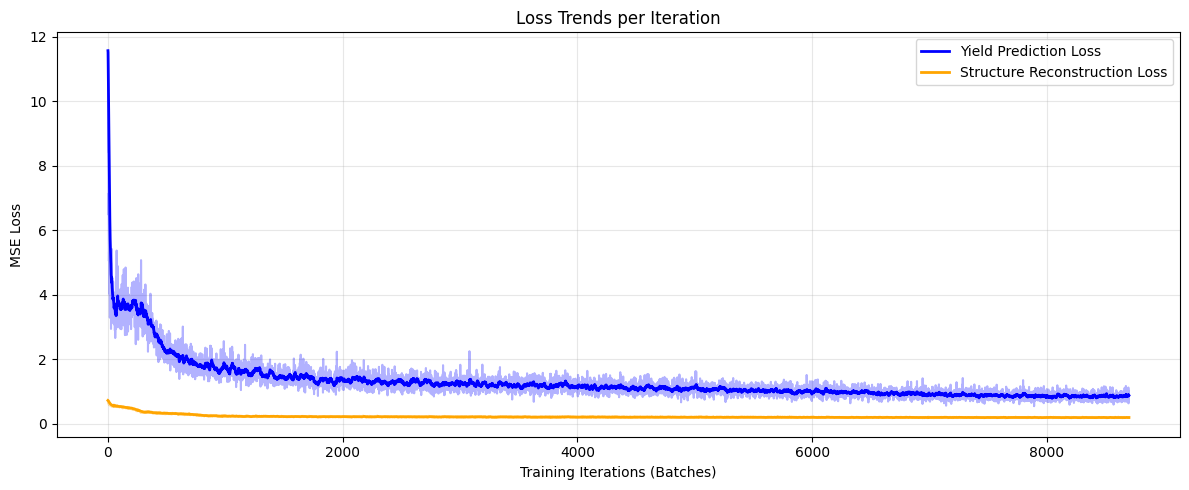

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

class RevIN(nn.Module):
    def __init__(self, num_features, eps=1e-5, affine=True):
        """
        Reversible Instance Normalization.
        Normalizes the input over the time dimension to handle distribution shift.
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        if self.affine:
            self._init_params()

    def _init_params(self):
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = 1  # Calculate stats over Sequence Length (dim 1)
        self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()
        return self.mean, self.stdev

    def normalize(self, x):
        mean, stdev = self._get_statistics(x)
        x = (x - mean) / stdev
        if self.affine:
            x = x * self.affine_weight + self.affine_bias
        return x

    def denormalize(self, x):
        if self.affine:
            x = (x - self.affine_bias) / (self.affine_weight + self.eps)
        x = x * self.stdev + self.mean
        return x

class CropTransformer(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, n_layers, max_seq_len, dropout=0.1):
        super().__init__()
        
        # RevIN for Input Features (Climate + Soil). 
        # We assume the last column is Yield and might treat it differently.
        self.revin = RevIN(input_dim - 1) 
        
        self.input_projection = nn.Linear(input_dim, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1, max_seq_len, d_model))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=d_model*4, 
            dropout=dropout, batch_first=True, activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, n_layers)
        self.output_projection = nn.Linear(d_model, input_dim)
        self.mask_token = nn.Parameter(torch.randn(1, 1, input_dim))

    def forward(self, x, mask_indices=None):
        batch_size, seq_len, n_feats = x.shape
        
        # --- 1. Apply RevIN (Distribution Shift Handling) ---
        # Strategy: Normalize Inputs (0:-1) to fix distribution shift.
        # Leave Yield (-1) raw to avoid leakage during the 'Yield Prediction' task.
        
        # Split Yield from Features
        x_feats = x[:, :, :-1]
        x_yield = x[:, :, -1:]
        
        # Normalize Features ONLY
        x_feats = self.revin.normalize(x_feats)
        
        # Recombine
        x = torch.cat([x_feats, x_yield], dim=-1)

        # --- 2. Apply Masking ---
        if mask_indices is not None:
            mask_token_expanded = self.mask_token.expand(batch_size, seq_len, -1)
            x = torch.where(mask_indices, mask_token_expanded, x)

        # --- 3. Transformer Block ---
        x = self.input_projection(x) + self.pos_encoding[:, :seq_len, :]
        x = self.transformer(x)
        x = self.output_projection(x)
        
        # --- 4. Denormalize (Optional) ---
        # Since we only normalized inputs, we should technically denormalize the 
        # predicted inputs to calculate loss in the original space.
        
        pred_feats = x[:, :, :-1]
        pred_yield = x[:, :, -1:]
        
        pred_feats = self.revin.denormalize(pred_feats)
        
        # Return recombined full prediction
        return torch.cat([pred_feats, pred_yield], dim=-1)

def create_dual_objective_mask(inputs, yield_idx=-1, block_size=20, random_prob=0.15):
    """
    Splits the batch into two objectives:
    1. Yield Prediction (First half of batch)
    2. Structure Learning (Second half of batch: Random Index OR Block Masking)
    """
    batch_size, seq_len, n_feats = inputs.shape
    mask = torch.zeros_like(inputs, dtype=torch.bool)
    split_idx = batch_size // 2
    mask[:split_idx, :, yield_idx] = True
    use_block = torch.rand(batch_size - split_idx) > 0.5
    for i in range(split_idx, batch_size):
        is_block_mode = use_block[i - split_idx]
        if is_block_mode:
            start = torch.randint(0, seq_len - block_size, (1,)).item()
            mask[i, start:start+block_size, :] = True
        else:
            rand_time_mask = torch.rand(seq_len) < random_prob
            mask[i, rand_time_mask, :] = True
    return mask, split_idx

def train_one_epoch(model, dataloader, optimizer, scheduler, device, yield_idx=-1):
    model.train()
    epoch_yield_losses = []
    epoch_struct_losses = []
    
    pbar = tqdm(dataloader, desc="Training")
    for inputs in pbar:
        mask, split_idx = create_dual_objective_mask(inputs, yield_idx=yield_idx)
        
        optimizer.zero_grad()
        outputs = model(inputs, mask_indices=mask)
        
        # 1. Yield Loss
        yield_preds = outputs[:split_idx]
        yield_targets = inputs[:split_idx]
        yield_mask = mask[:split_idx]
        
        if yield_mask.any():
            loss_yield = nn.functional.mse_loss(yield_preds[yield_mask], yield_targets[yield_mask])
        else:
            loss_yield = torch.tensor(0.0, device=device, requires_grad=True)
        
        # 2. Structure Loss
        struct_preds = outputs[split_idx:]
        struct_targets = inputs[split_idx:]
        struct_mask = mask[split_idx:]
        
        if struct_mask.any():
            loss_struct = 1e-3*nn.functional.mse_loss(struct_preds[struct_mask], struct_targets[struct_mask])
        else:
            loss_struct = torch.tensor(0.0, device=device, requires_grad=True)
        
        total_loss = loss_yield + loss_struct
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
        epoch_yield_losses.append(loss_yield.item())
        epoch_struct_losses.append(loss_struct.item())
        
        pbar.set_postfix({'L_Yield': f"{loss_yield.item():.4f}", 'L_Struct': f"{loss_struct.item():.4f}"})
        
    return epoch_yield_losses, epoch_struct_losses

def plot_training_history(yield_history, struct_history):
    plt.figure(figsize=(12, 5))
    def smooth(scalars, weight=0.9):
        if not scalars: return []
        last = scalars[0]
        smoothed = []
        for point in scalars:
            smoothed_val = last * weight + (1 - weight) * point
            smoothed.append(smoothed_val)
            last = smoothed_val
        return smoothed

    plt.plot(yield_history, alpha=0.3, color='blue')
    plt.plot(struct_history, alpha=0.3, color='orange')
    plt.plot(smooth(yield_history), label='Yield Prediction Loss', color='blue', linewidth=2)
    plt.plot(smooth(struct_history), label='Structure Reconstruction Loss', color='orange', linewidth=2)
    plt.title("Loss Trends per Iteration")
    plt.xlabel("Training Iterations (Batches)")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True, which='both', alpha=0.3)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Hyperparameters
    BATCH_SIZE = 512
    SEQ_LEN = 240
    N_FEATURES = 9 
    D_MODEL = 64
    N_HEADS = 4
    N_LAYERS = 2
    EPOCHS = 20
    LR = 1e-2
    DROPOUT_RATE = 0.4
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    loader = DataLoader(train_wheat, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

    model = CropTransformer(N_FEATURES, D_MODEL, N_HEADS, N_LAYERS, SEQ_LEN, DROPOUT_RATE).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, steps_per_epoch=len(loader), epochs=EPOCHS)

    all_yield_losses = []
    all_struct_losses = []

    print("Starting Training with Split Batch Strategy...")
    for epoch in range(EPOCHS):
        y_losses, s_losses = train_one_epoch(model, loader, optimizer, scheduler, device)
        all_yield_losses.extend(y_losses)
        all_struct_losses.extend(s_losses)
        if (epoch + 1) % 1 == 0:
            print(f"Epoch {epoch+1} Avg | Yield: {np.mean(y_losses):.4f} | Struct: {np.mean(s_losses):.4f}")

    plot_training_history(all_yield_losses, all_struct_losses)

In [19]:
## validation loss ##
val_loader = DataLoader(val_wheat,batch_size=1024)
val_losses = []
model.train()
with torch.no_grad():
        
    for inputs in val_loader:
        yield_mask = torch.zeros_like(inputs,dtype=torch.bool)
        yield_mask[:,:,-1] = True
        outputs = model(inputs, yield_mask)
        loss = torch.nn.functional.mse_loss(outputs[yield_mask],inputs[yield_mask])
        val_losses.append(loss.item())

np.mean(val_losses)

1.5219066619873047